<a href="https://colab.research.google.com/github/ensarakbas77/Transformer-Model-Training/blob/main/BeIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize
import numpy as np
import time
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PatchExtractor ve TransformerBlock Sınıflarının Tanımlanması
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, inputs):
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(inputs)[0], -1, patch_dims])
        return patches

class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, ff_dim):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(ff_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=None):
        attention_output = self.attention(inputs, inputs)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Veri Seti Yükleme ve Hazırlama
IMG_SIZE = 224
BATCH_SIZE = 16
train_dir = "/content/drive/My Drive/DDATA_SET/train"
test_dir = "/content/drive/My Drive/DDATA_SET/test"

# Eğitim ve test setlerini yükleme
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Veri setlerinden etiketleri çıkarma
train_labels = np.concatenate([y for _, y in train_dataset], axis=0)
test_labels = np.concatenate([y for _, y in test_dataset], axis=0)

# Sınıf sayısı
num_classes = 5

# Kullanmak istediğiniz sınıflar
selected_classes = [0, 1, 2, 3, 4]

Found 2112 files belonging to 5 classes.
Found 528 files belonging to 5 classes.


In [ ]:
# Eğitim setini filtreleme
train_filter = np.isin(train_labels, selected_classes)
train_labels = train_labels[train_filter]
train_images = np.concatenate([x for x, _ in train_dataset], axis=0)[train_filter]

# Test setini filtreleme
test_filter = np.isin(test_labels, selected_classes)
test_labels = test_labels[test_filter]
test_images = np.concatenate([x for x, _ in test_dataset], axis=0)[test_filter]

# Etiketleri yeniden düzenleme (0-4 aralığına getir)
train_labels = np.array([np.where(selected_classes == label)[0][0] for label in train_labels])
test_labels = np.array([np.where(selected_classes == label)[0][0] for label in test_labels])

# Etiketleri kategorik hale getirme
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

print(f"Filtered training data shape: {train_images.shape}")
print(f"Filtered test data shape: {test_images.shape}")

# Normalizasyon ve augmentasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

Filtered training data shape: (2112, 224, 224, 3)
Filtered test data shape: (528, 224, 224, 3)


In [ ]:
def preprocess(image, label):
    image = normalization_layer(image)  # Normalizasyon
    image = data_augmentation(image)    # Veri augmentasyonu
    image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    return image, label

train_dataset = train_dataset.map(preprocess).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

class BeITModel(tf.keras.Model):
    def __init__(self, num_patches, projection_dim, num_classes):
        super(BeITModel, self).__init__()
        self.patch_extractor = PatchExtractor(patch_size=16)
        self.projection = layers.Dense(units=projection_dim)
        self.transformer = TransformerBlock(num_heads=8, ff_dim=projection_dim)
        self.global_pool = layers.GlobalAveragePooling1D()  # Flatten yerine GlobalAveragePooling1D
        self.classifier = layers.Dense(units=num_classes, activation='softmax')

    def call(self, inputs, training=None):
        patches = self.patch_extractor(inputs)
        projected = self.projection(patches)
        transformed = self.transformer(projected, training=training)
        pooled = self.global_pool(transformed)
        return self.classifier(pooled)

# Model parametreleri
num_patches = (224 // 16) ** 2  # 14x14 patches
projection_dim = 128
num_classes = 5


In [ ]:
# Model oluşturma
beit_model = BeITModel(num_patches=num_patches, projection_dim=projection_dim, num_classes=num_classes)

# Derleme
beit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
beit_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
history = beit_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)
training_time = time.time() - start_time
print(f"Eğitim Zamanı: {training_time:.2f} saniye")

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 145s 798ms/step - accuracy: 0.2067 - loss: 1.7041 - val_accuracy: 0.2235 - val_loss: 1.6498
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 102s 773ms/step - accuracy: 0.2097 - loss: 1.6268 - val_accuracy: 0.2121 - val_loss: 1.6026
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 108s 820ms/step - accuracy: 0.2678 - loss: 1.5923 - val_accuracy: 0.2348 - val_loss: 1.6017
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 139s 801ms/step - accuracy: 0.2449 - loss: 1.5952 - val_accuracy: 0.2936 - val_loss: 1.5859
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 147s 834ms/step - accuracy: 0.2567 - loss: 1.5912 - val_accuracy: 0.2652 - val_loss: 1.5875
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 110s 834ms/step - accuracy: 0.2629 - loss: 1.5719 - val_accuracy: 0.2424 - val_loss: 1.5843
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 143s 837ms/step - accuracy: 0.3086 - loss: 1.5495 - val_accuracy: 0.2405 - val_loss: 1.5896
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 109s 830ms/step - accuracy: 0.2979 -

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step


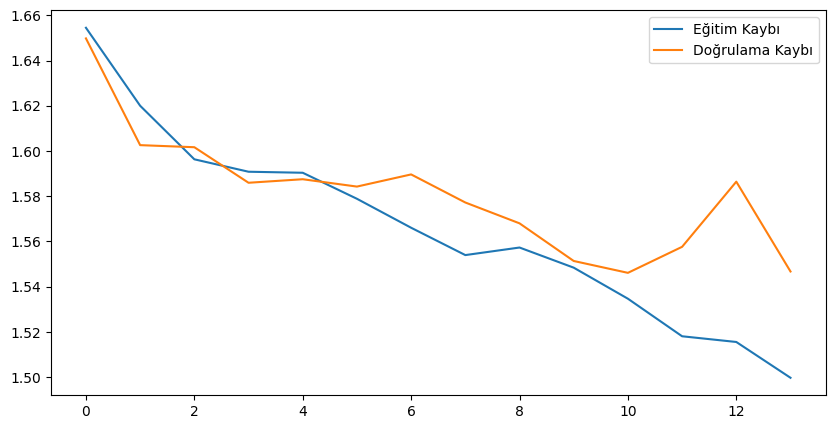

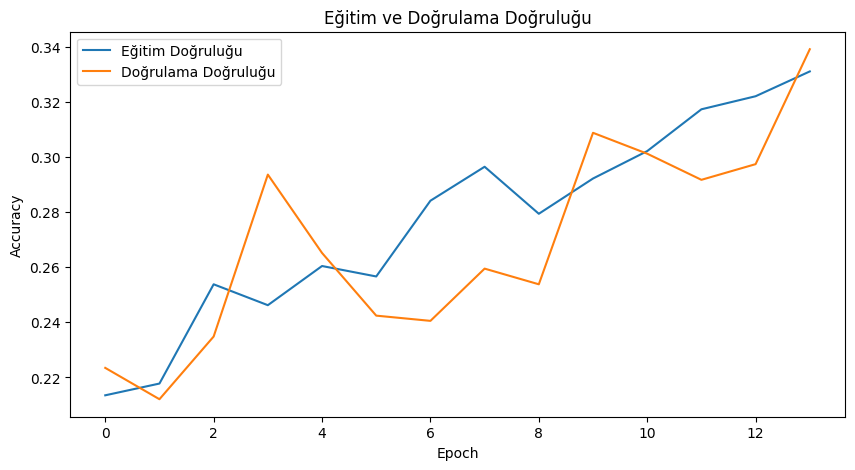

In [ ]:
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_probs = beit_model.predict(test_dataset)
y_pred = np.argmax(y_probs, axis=1)


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history.get('accuracy', []), label='Eğitim Doğruluğu')
plt.plot(history.history.get('val_accuracy', []), label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()



33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step
Çıkarım Süresi: 12.22 saniye
Karmaşıklık Matrisi:
 [[24 14 18  2 48]
 [ 4 37 36  6 23]
 [ 7 24 44  6 25]
 [15 35 21 17 18]
 [15 24 19  9 37]]
Sensitivity (Recall): {0: 0.22641509433962265, 1: 0.3490566037735849, 2: 0.41509433962264153, 3: 0.16037735849056603, 4: 0.3557692307692308}
Specificity: {0: 0.9028436018957346, 1: 0.7701421800947867, 2: 0.7772511848341233, 3: 0.9454976303317536, 4: 0.7311320754716981}
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.37      0.23      0.28       106
           1       0.28      0.35      0.31       106
           2       0.32      0.42      0.36       106
           3       0.42      0.16      0.23       106
           4       0.25      0.36      0.29       104

    accuracy                           0.30       528
   macro avg       0.33      0.30      0.29       528
weighted avg       0.33      0.30      0.29       528



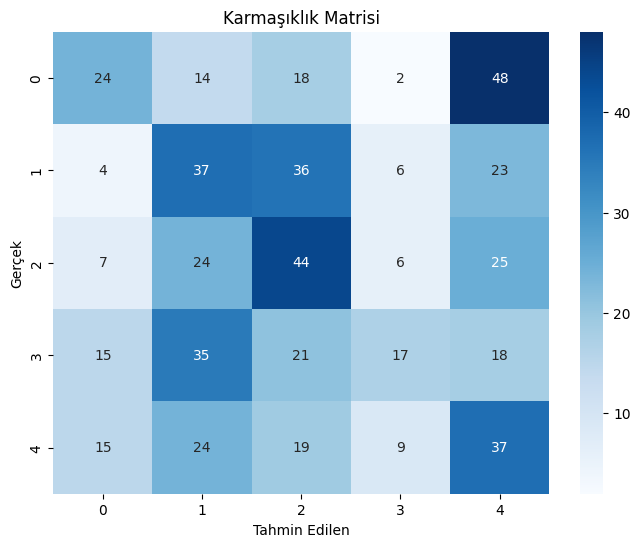

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import time
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Test veri kümesi üzerinde çıkarım süresi
start_time = time.time()
y_pred_probs = beit_model.predict(test_dataset)
inference_time = time.time() - start_time
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")

# Metrik hesaplama
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Karmaşıklık Matrisi
conf_matrix = confusion_matrix(y_true, y_pred)
print("Karmaşıklık Matrisi:\n", conf_matrix)

# Sensitivity (Recall) ve Specificity Hesaplama
sensitivity = {}
specificity = {}
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - tp
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (tp + fn + fp)
    sensitivity[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")

# Classification Raporu
class_report = classification_report(y_true, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karmaşıklık Matrisi görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()


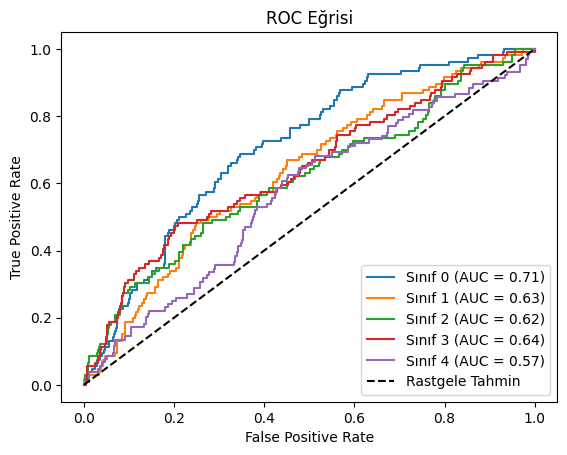

In [ ]:
# Gerçek etiketleri one-hot encode edin
y_true_binarized = label_binarize(y_true, classes=range(num_classes))

# ROC eğrisi ve AUC hesaplaması
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çiz
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Sınıf {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


image_paths = [
    '/content/image_1.png',
    '/content/image_2.png',
    '/content/image_3.png',
    '/content/image_4.png',
    '/content/image_5.png'
]


for i, image_path in enumerate(image_paths, 1):

    img = image.load_img(image_path, target_size=(224, 224))  # İndirilen dosya yolunu kullan

    # Fotoğrafı numpy dizisine dönüştürme
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Fotoğrafı normalize etme
    img_array = img_array / 255.0

    # Tahmin yapma
    predictions = beit_model.predict(img_array)

    # Tahmin edilen sınıf
    predicted_class = np.argmax(predictions, axis=-1)

    # class_names = list(test_dataset.class_indices.keys())

    class_names = ["kifoz", "pektus_ekskavatum", "pektus_karinatum", "poland_sendromu", "skolyoz"]  # Sınıf isimlerini buraya yazın


    print(f"{i}. Resim: Tahmin Edilen Sınıf: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1. Resim: Tahmin Edilen Sınıf: pektus_karinatum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2. Resim: Tahmin Edilen Sınıf: skolyoz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3. Resim: Tahmin Edilen Sınıf: pektus_karinatum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4. Resim: Tahmin Edilen Sınıf: pektus_ekskavatum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
5. Resim: Tahmin Edilen Sınıf: kifoz
